In [12]:
import itertools
from typing import Tuple

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import StatevectorSimulator, AerSimulator


sim = StatevectorSimulator()

## Solving CHSH Game with Gradient Descent

We start from the bell state $|\phi^+\rangle = 1/\sqrt{2} (|00\rangle + |11\rangle)$, which is constructed with `get_bell_state`. Then, the qubits are presumably separated, and Alice and Bob each choose measurement angles $\alpha$ and $\beta$ in accordance to their policies $\pi_a(\alpha | x), \pi_b(\beta | y)$, which they could have coordinated before separation. This is implemented as $R_y$ gates on each qubit in `get_shared_state`.

To compute the value of the game, $V^\pi$ where $\pi$ is the composite policy/strategy of both Alice and Bob, we iterate over each set of questions $x, y \in \{0, 1\}$. If $x = y = 1$, the probability of them winning is $p(a \neq b) = |\langle 01|\psi\rangle|^2 + |\langle 10|\psi\rangle|^2$. Otherwise, we measure the probability of $|00\rangle$ and $|11\rangle$ instead, since their answers should agree.

We assume Alice and Bob each use a deterministic policy, therefore choosing e.g. $\alpha_0$ if $x = 0$. This leads to a parameterization of $V^\pi(\alpha_0, \alpha_1, \beta_0, \beta_1) = V^\pi(\mathbf{\theta})$. We maximize $V$ following the gradient $\nabla_\theta V$, and this gives us the highest possible quantum strategy probability.

In [2]:
def get_bell_circuit() -> QuantumCircuit:
    # Construct circuit with 2 qubits and 2 bits
    qc = QuantumCircuit(2, 2)

    # Hadamard on alice's qubit, then cnot on bob
    qc.h(0)
    qc.cx(0, 1)

    # 1/√2 (|00> + |11>)
    return qc

def get_shared_state() -> Tuple[QuantumCircuit, Tuple[Parameter, Parameter]]:
    qc = get_bell_circuit()
    alice = Parameter('α')
    bob = Parameter('β')

    qc.ry(alice, 0)
    qc.ry(bob, 1)

    return qc, (alice, bob)

def V(x):
    a0, a1, b0, b1 = x
    v = 0

    qc, (alice, bob) = get_shared_state()
    for x, y in itertools.product((0, 1), (0, 1)):
        # Perform conditional rotations on alice and bob qubits
        bound_qc = qc.bind_parameters({
            alice: a0 if x == 0 else a1,
            bob: b0 if y == 0 else b1
        })

        compiled = transpile(bound_qc, sim)
        job = sim.run(compiled)
        result = job.result()

        # Get statevector
        state = result.get_statevector(compiled)
        prob = np.abs(state) ** 2

        if x == 1 and y == 1:
            # Check 01 and 10 probability
            p = prob[1] + prob[2]
        else:
            # Check 00 and 11 probability
            p = prob[0] + prob[3]
        
        v += 0.25 * p
    
    return v

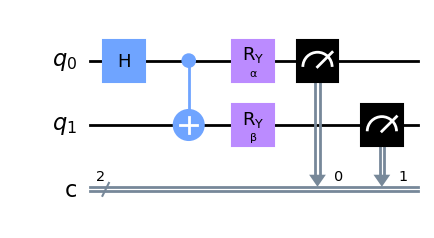

In [3]:
qc = get_shared_state()[0]
qc.measure((0, 1), (0, 1))
qc.draw('mpl')

There's a local maximum at $\theta = [0~0~0~0]^T$ corresponding to the classical win rate: since Alice and Bob don't choose different measurement settings based on the questions, their answers always agree by entanglement just like the classical deterministic strategy. This point is a local maximum since slight pertubations around the optimal classical strategy should slightly reduce the frequency their answers agree, leading to a lower win rate.

Preparing a Bell state of $|\psi^\pm\rangle = 1/\sqrt{2}(|01\rangle \pm |10\rangle)$ instead of $|\phi^\pm\rangle$ should have a win rate of 25%, but this should not be a local maximum since any perturbation results in agreeing more often, increasing the win rate.

In [8]:
res = minimize(lambda x: -V(x), [0, 0, 0, 0])
print(f'Success probability: {-res.fun:.3f}')
print(f'Angles: {res.x}')

Success probability: 0.750
Angles: [0. 0. 0. 0.]


A slight pertubation gets us to the optimal quantum win rate

In [9]:
res = minimize(lambda x: -V(x), [0, 1e-2, 0, 0])
print(f'Success probability: {-res.fun:.3f}')
print(f'Angles: {res.x}')

Success probability: 0.854
Angles: [-0.39020038  1.18059621  0.39519916 -1.17559894]


Constraining $\alpha_0 = 0$ does not affect our win rate, and it gives us parameters seen before in literature.

In [10]:
# Repeat constraining a0 = 0 to reproduce the paper
cons = [
    {'type': 'eq', 'fun': lambda x: x[0]}
]
res = minimize(lambda x: -V(x), [0, 1e-2, 0, 0], constraints=cons)
print(f'Success probability: {-res.fun:.3f}')
print(f'Angles: {res.x}')

Success probability: 0.854
Angles: [ 0.          1.57369062  0.78694986 -0.78293087]


Interestingly, if we also constrain $\beta_0 = 0$, we can still do better than the classical strategy but create a suboptimal quantum strategy.

In [11]:
# Can we also constrain Bob (b0 = 0) and still do well?.. better than classical but suboptimal
cons = [
    {'type': 'eq', 'fun': lambda x: x[0]},
    {'type': 'eq', 'fun': lambda x: x[2]},
]
res = minimize(lambda x: -V(x), [0, 1e-2, 0, 0], constraints=cons)
print(f'Success probability: {-res.fun:.3f}')
print(f'Angles: {res.x}')

Success probability: 0.812
Angles: [ 0.          1.04586804  0.         -1.04762649]


### Optimization Landscape

An important question is: how pathological is this function to optimize? If the CHSH landscape is complicated, that will make it really difficult to directly optimize future, larger quantum games.

In this section, we measure the gradient $\nabla_\theta V$ for $\theta = [0~\alpha_1~0~\beta_1]^T$. We constrain both Alice and Bob just like above for the purposes of visualization. The white dot represents the suboptimal quantum strategy.

In [27]:
N = 26
angles = np.linspace(-np.pi, np.pi, N, endpoint=True)
data = np.zeros((N, N, 4))
h = 1e-6

for ai, bi in itertools.product(range(N), range(N)):
    a1, b1 = angles[ai], angles[bi]
    x = [0, a1, 0, b1]
    Vx = V(x)
    for ei in range(4):
        dx = h * np.array([1 if i == ei else 0 for i in range(4)])
        Vxh = V(x + dx)
        dV = (Vxh - Vx) / h
        data[ai, bi, ei] = dV

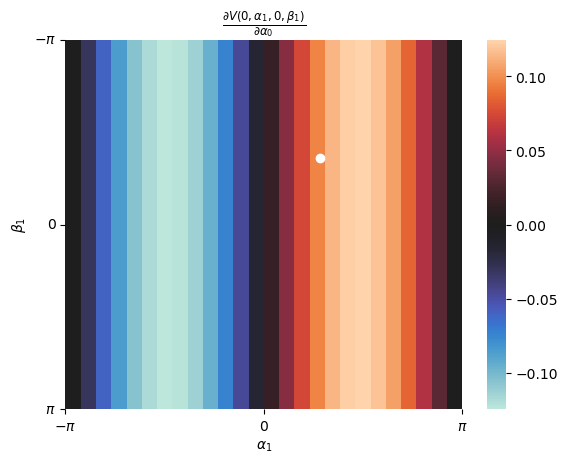

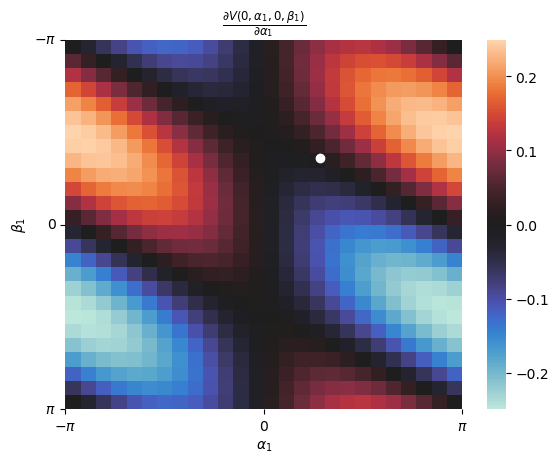

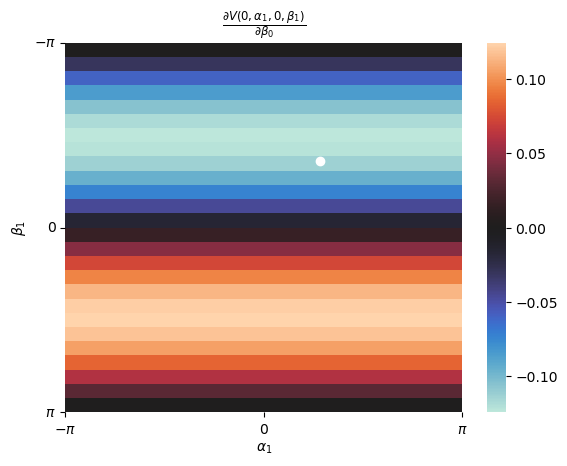

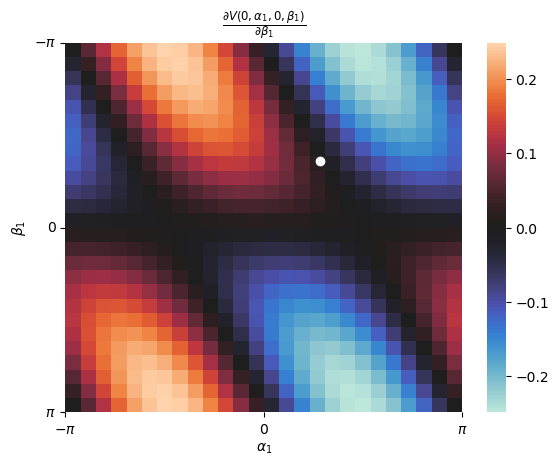

In [31]:
varnames = ['\\alpha_0', '\\alpha_1', '\\beta_0', '\\beta_1']
for i, varname in enumerate(varnames):
    sns.heatmap(data[:, :, i], center=0, cmap='icefire')
    plt.xticks([0, N // 2, N], ['$-\pi$', 0, '$\pi$'], rotation=0)
    plt.yticks([0, N // 2, N], ['$-\pi$', 0, '$\pi$'], rotation=0)

    plt.xlabel('$\\alpha_1$')
    plt.ylabel('$\\beta_1$')

    suboptimal = res.x
    suboptimal = np.interp(suboptimal, angles, np.arange(N))
    plt.plot(suboptimal[1], suboptimal[3], marker='o', color='white')

    plt.title(f'$\\frac{{\partial V(0, \\alpha_1, 0, \\beta_1)}}{{\\partial {varname}}}$')
    plt.show()

We can also look at the convergence plot of the fully unconstrained case, measuring the game value at each algorithm iteration. (As it turns out, you can't receive the gradient in `scipy.optimize` callbacks..)

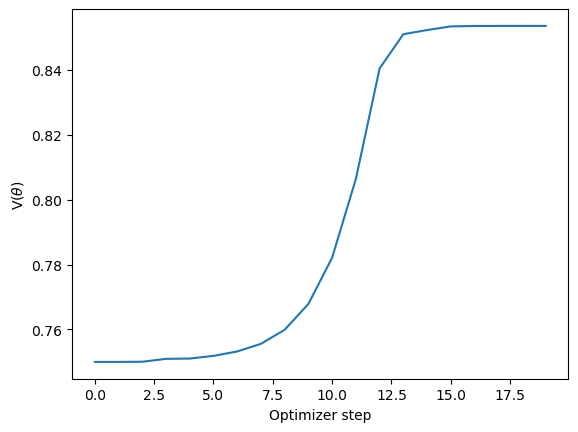

In [33]:
data = []
res = minimize(lambda x: -V(x), [0, 1e-2, 0, 0],
               callback=lambda x: data.append(V(x)))

plt.plot(range(len(data)), data)
plt.xlabel('Optimizer step')
plt.ylabel('V($\\theta$)')
plt.show()

### Adapt on CHSH inequality

$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\renewcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\renewcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\renewcommand{\expect}[1]{\left\langle{#1}\right\rangle}$$

We fix the measurement settings to $\phi = [\alpha_0~\alpha_1~\beta_0~\beta_1]^T$, which we can draw a random distribution or try to replicate known results with an initial setting. Then this yields a hamiltonian

$$H = -\sum_{q \in Q} c_q M(\phi_q),$$

where $q = (q_1, q_2, ...)$ encodes the questions asked of each player, and $Q$ enumerates all possible question combinations. For the case of the CHSH game, this evaluates to

$$H = -\left[M(\phi_0^a)M(\phi_0^b) + M(\phi_1^a)M(\phi_0^b) + M(\phi_0^a)M(\phi_1^b) - M(\phi_1^a)M(\phi_1^b)\right].$$

Or using the notation/parameters above with $\phi_i^a = \alpha_i$ and $\phi_i^b = \beta_i$. Measuring the expectation value $\expect{H}$ gives the quantum violation of the inequality, with the ground state corresponding to the optimal state.

In [ ]:
from adap

### Todo
 - Do ADAPT on CHSH by using inequality operator as hamiltonian (optimize inequality)
 - ... optimize winning probability numerically (unless analytical derivative exists)
 - ~~Plot grad. of scipy over iterations~~
 - Design dense reward of CHSH with small ansatz in RL loop. Measure inequality at each timestep
 - Move on to $N$-partite game (ADAPT, RL loop (fixed ansatz), grad descent (fixed ansatz))